If you're opening this Notebook on colab, you will probably need to install 🤗 Transformers and 🤗 Datasets. Uncomment the following cell and run it.

In [ ]:
#! pip install datasets transformers

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Then you need to install Git-LFS. Uncomment the following instructions:

In [ ]:
# !apt install git-lfs

Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version:

In [1]:
import transformers

print(transformers.__version__)

4.28.1


You can find a script version of this notebook to fine-tune your model in a distributed fashion using multiple GPUs or TPUs [here](https://github.com/huggingface/transformers/tree/master/examples/language-modeling).

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [2]:
from transformers.utils import send_example_telemetry

send_example_telemetry("language_modeling_from_scratch_notebook", framework="pytorch")

# Train a language model

In this notebook, we'll see how to train a [🤗 Transformers](https://github.com/huggingface/transformers) model on a language modeling task. We will cover two types of language modeling tasks which are:

- Causal language modeling: the model has to predict the next token in the sentence (so the labels are the same as the inputs shifted to the right). To make sure the model does not cheat, it gets an attention mask that will prevent it to access the tokens after token i when trying to predict the token i+1 in the sentence.

![Widget inference representing the causal language modeling task](images/causal_language_modeling.png)

- Masked language modeling: the model has to predict some tokens that are masked in the input. It still has access to the whole sentence, so it can use the tokens before and after the tokens masked to predict their value.

We will see how to easily load and preprocess the dataset for each one of those tasks, and how to use the `Trainer` API to train a model on it.

This notebooks assumes you have trained a tokenizer on the corpus you are using, see the [How to train a tokenizer](https://github.com/huggingface/notebooks/blob/master/examples/tokenizer_training.ipynb) notebook ([open in colab](https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/tokenizer_training.ipynb)).

A script version of this notebook you can directly run on a distributed environment or on TPU is available in our [examples folder](https://github.com/huggingface/transformers/tree/master/examples).

## Preparing the dataset

For each of those tasks, we will use the [Wikitext 2]() dataset as an example. You can load it very easily with the 🤗 Datasets library.

In [7]:
# from datasets import load_dataset
# datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')

In [8]:
import os
os.getcwd()

'/workspace/kogpt'

You can replace the dataset above with any dataset hosted on [the hub](https://huggingface.co/datasets) or use your own files. Just uncomment the following cell and replace the paths with values that will lead to your files:

In [11]:
datasets = load_dataset("text", data_files={"train": 'oo.txt', "validation": 'oo.txt'})

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-b7a5349f439f245a/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

You can also load datasets from a csv or a JSON file, see the [full documentation](https://huggingface.co/docs/datasets/loading_datasets.html#from-local-files) for more information.

To access an actual element, you need to select a split first, then give an index:

In [12]:
len(datasets['train']['text'])

3172

In [13]:
datasets

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 3172
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3172
    })
})

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [14]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [15]:
show_random_elements(datasets["train"])

,text
0,"오브젠은 국내 클라우드 전환 추세에 맞춰 고객사의 IT 환경과 니즈에 따라 구축형 솔루션과 구독형 솔루션 중 선택할 수 있는 도입 옵션을 제공할 것입니다. 또한, 고객사가 어느 솔루션을 선택했는지와 상관없이 구축형-구독형 솔루션 간의 선순환 과정에서 도출된 인사이트를 바탕으로 운영중에 지속적인 가치 제안 서비스를 제공함으로써, 고객사를 Lock-In 하고 솔루션의 재구축 및 확장구축으로 이어지게 될 것입니다."
1,"CRM 컨설턴트의 다양한 경험 : 광고사 PI(제일기획, 이노션), 광고 연계 마케팅(현대자동차, 르노삼성자동차), 외부 데이터사 연계 마케팅(신한금융투자) 등"
2,[obzen vs. Tibco 비교 검토 결과 요약]
3,고객 빅데이터 통합 플랫폼을 위한 모듈형 기반 기술
4,마케팅 비대상 고객 가운데 유사-대조군을 추출해내는 접근법은 기본적으로 RCM(Rubin Causal Model)의 프레임워크를 이용
5,"Strategy Lab을 맡고 있는 김홍구 전무는 PWC, IBM GBS, EY Advisory, Deloitte Consulting 등 다수의 글로벌 컨설팅 회사에서 근무해 온 CRM 전문 컨설턴트 출신입니다. Deloitte Consulting에서는 파트너로 근무하며 CRM 전략 수립, 빅데이터 플랫폼 구축, AI 서비스 개발 등 오브젠의 다양한 사업 영역과 관련된 프로젝트를 수행하였습니다. 이와 같은 경험을 기반으로, 다양한 분야의 컨설팅 경험을 보유하고 있는 컨설턴트들로 Strategy Lab을 구성하고, 회사 내의 전략적 부서로 필요한 역할을 수행하고 있습니다."
6,Communication 제품 수명 주기
7,Auto Feature Engineering
8,"오브젠의 제품은 디지털/언택트 환경을 기반으로 하고 있으며, 오랜 기간 금융권 및 매장을 보유하고 있는 대형 유통사에 디지털 마케팅 제품을 납품하여 산업별로 다른 고객의 니즈를 잘 파악하고 있습니다. 고객의 디지털 채널 행동 데이터를 실시간으로 분석하고 특정 행동을 수행한 고객의 보유 상품이나 거래 이력, 프로필 데이터 등의 오프라인 데이터와 결합하여 마케팅 수행 대상 고객을 세부적으로 선별하여 각각의 고객에게 적합한 마케팅을 수행할 수 있습니다."
9,어디서나 데이터 인사이트 확보


As we can see, some of the texts are a full paragraph of a Wikipedia article while others are just titles or empty lines.

## Causal Language modeling

For causal language modeling (CLM) we are going to take all the texts in our dataset and concatenate them after they are tokenized. Then we will split them in examples of a certain sequence length. This way the model will receive chunks of contiguous text that may look like:
```
part of text 1
```
or 
```
end of text 1 [BOS_TOKEN] beginning of text 2
```
depending on whether they span over several of the original texts in the dataset or not. The labels will be the same as the inputs, shifted to the left.

We will use the [`gpt2`](https://huggingface.co/gpt2) architecture for this example. You can pick any of the checkpoints listed [here](https://huggingface.co/models?filter=causal-lm) instead. For the tokenizer, you can replace the checkpoint by the one you trained yourself.

In [7]:
# model_checkpoint = "gpt2"
# tokenizer_checkpoint = "sgugger/gpt2-like-tokenizer"

In [16]:
from transformers import GPT2LMHeadModel
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
                                                    bos_token='</s>', eos_token='</s>', unk_token='<unk>',
                                                    pad_token='<pad>', mask_token='<mask>')
print(tokenizer.tokenize("안녕하세요. 한국어 GPT-2 입니다.😤:)l^o"))
# ['▁안녕', '하', '세', '요.', '▁한국어', '▁G', 'P', 'T', '-2', '▁입', '니다.', '😤', ':)', 'l^o']


model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


['▁안녕', '하', '세', '요.', '▁한국어', '▁G', 'P', 'T', '-2', '▁입', '니다.', '😤', ':)', 'l^o']


In [17]:
# data config
IGNORE_INDEX = -100
DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "</s>"
DEFAULT_UNK_TOKEN = "</s>"

In [22]:
import transformers
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "skt/kogpt2-base-v2",
    padding_side="right",
    model_max_length=512,    
)
tokenizer.add_special_tokens(
    {
        "eos_token": DEFAULT_EOS_TOKEN,
        "bos_token": DEFAULT_BOS_TOKEN,
        "unk_token": DEFAULT_UNK_TOKEN,
    }
)    
tokenizer.pad_token = tokenizer.eos_token
print(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


In [23]:
model = model.to('cuda')

To tokenize all our texts with the same vocabulary that was used when training the model, we have to download a pretrained tokenizer. This is all done by the `AutoTokenizer` class:

In [8]:
# from transformers import AutoTokenizer
    
# tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)

We can now call the tokenizer on all our texts. This is very simple, using the [`map`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map) method from the Datasets library. First we define a function that call the tokenizer on our texts:

In [24]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

Then we apply it to all the splits in our `datasets` object, using `batched=True` and 4 processes to speed up the preprocessing. We won't need the `text` column afterward, so we discard it.

In [25]:
tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

Map (num_proc=4):   0%|          | 0/3172 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3172 [00:00<?, ? examples/s]

In [26]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 3172
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 3172
    })
})

If we now look at an element of our datasets, we will see the text have been replaced by the `input_ids` the model will need:

In [27]:
examples = tokenized_datasets["train"][:10]
res = group_texts(examples)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 examples = tokenized_datasets["train"][:10]                                                  │
│ ❱ 2 res = group_texts(examples)                                                                  │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'group_texts' is not defined

In [32]:
res['input_ids'][0], res['labels'][0]

([238,
  8576,
  9441,
  2987,
  238,
  252,
  4657,
  74,
  4762,
  826,
  8576,
  428,
  466,
  609,
  6881,
  412,
  204,
  9441,
  311,
  2746,
  466,
  10816,
  168,
  99,
  150,
  192,
  112,
  14328,
  3983,
  112,
  4446,
  94,
  18288,
  4446,
  193,
  3983,
  98,
  3983,
  22171,
  95,
  19,
  201,
  6374,
  209,
  8576,
  218,
  198,
  3455,
  1972,
  428,
  310,
  201,
  5099,
  3242,
  227,
  281,
  8576,
  9441,
  2987,
  2553,
  1759,
  201,
  301,
  196,
  13996,
  1496,
  277,
  2330,
  1464,
  674,
  1898,
  307,
  742,
  3541,
  225,
  7514,
  14,
  54,
  719,
  274,
  198,
  4777,
  15522,
  209,
  19895,
  221,
  1341,
  1633,
  221,
  1759,
  201,
  322,
  301,
  198,
  1368,
  674,
  221,
  198,
  8576,
  843,
  209,
  2468,
  1795,
  223,
  198,
  1049,
  9595,
  218,
  13996,
  225,
  1563,
  277,
  582,
  6493,
  281,
  457,
  14371,
  201,
  198,
  1422,
  3373,
  7452,
  227,
  198,
  455,
  674,
  225,
  4687],
 [238,
  8576,
  9441,
  2987,
  238,
  252,
 

Now for the harder part: we need to concatenate all our texts together then split the result in small chunks of a certain `block_size`. To do this, we will use the `map` method again, with the option `batched=True`. This option actually lets us change the number of examples in the datasets by returning a different number of examples than we got. This way, we can create our new samples from a batch of examples.

First, we grab the maximum length our model was pretrained with. This might be a big too big to fit in your GPU RAM, so here we take a bit less at just 128.

In [28]:
# block_size = tokenizer.model_max_length
block_size = 128

Then we write the preprocessing function that will group our texts:

In [29]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

First note that we duplicate the inputs for our labels. This is because the model of the 🤗 Transformers library apply the shifting to the right, so we don't need to do it manually.

Also note that by default, the `map` method will send a batch of 1,000 examples to be treated by the preprocessing function. So here, we will drop the remainder to make the concatenated tokenized texts a multiple of `block_size` every 1,000 examples. You can adjust this behavior by passing a higher batch size (which will also be processed slower). You can also speed-up the preprocessing by using multiprocessing:

In [30]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

Map (num_proc=4):   0%|          | 0/3172 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3172 [00:00<?, ? examples/s]

And we can check our datasets have changed: now the samples contain chunks of `block_size` contiguous tokens, potentially spanning over several of our original texts.

In [33]:
tokenizer.decode(lm_datasets["train"][1|0]["input_ids"])

'따라 발전했습니다. 현재도 중요하게 활용되는 관계형 데이터베이스 관리시스템(RDBMS) 자체는 1970년에 등장했지만 초창기엔 데이터 자체가 귀했기 때문에 작은 규모의 데이터를 통계적인 이론에 기반하여 분석하는 것이 주를 이루었습니다. 1990년대에 이르러 정보 통신 기술이 급격하게 발전하며 생성되는 데이터 양이 늘어남에 따라 데이터 자체를 다루는 것에 대한 중요성이 대두되었고, 이 시기에 MySQL, PostgreSQL 등 우수한 RDBMS 소프트웨어가 개발되었습니다. 2000년대 인터넷의 발전과 함께 데이터의 양은 더욱 폭발적으로 증가하며 단일 장치(Single Machine)에서의 처리 한계를 넘어서기 시작했습니다. 이 시기에 분산 빅데이터 파일'

Now that the data has been cleaned, we're ready to instantiate our `Trainer`. First we create the model using the same config as our checkpoint, but initialized with random weights:

In [37]:
# from transformers import AutoConfig, AutoModelForCausalLM

# config = AutoConfig.from_pretrained(model_checkpoint)
# model = AutoModelForCausalLM.from_config(config)

And we will needsome `TrainingArguments`:

In [34]:
from transformers import Trainer, TrainingArguments

In [35]:
training_args = TrainingArguments(
    f"obgpt",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=False,
    report_to='none'
)

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/gpt-finetuned-wikitext2"` or `"huggingface/gpt-finetuned-wikitext2"`).

We pass along all of those to the `Trainer` class:

In [36]:
print(tokenizer.special_tokens_map)
tokenizer.all_special_ids

{'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}


[1]

In [37]:
''.join(datasets['train']['text'][:10])

'<붙임>Ⅰ. 주요 기술 내용Ⅰ. 주요 기술 내용기술(제품)의 개요기술(제품) 개발 배경디지털 경제에서 데이터는 원유 혹은 전기에 비유되며, 기업 생존에 필수적인 자원으로 여겨지고 있습니다. 기술의 발전 속도가 점점 빨라지고, COVID-19 팬데믹과 같은 불확실성이 큰 사건들이 발생함에 따라, 과거의 개인적인 경험이나 직관보다 데이터에 기반한 의사결정이 더욱 중요해지고 있습니다. 이러한 이유로 많은 기업들이 데이터 수집, 축적, 처리, 분석 등 데이터의 체계적 사용을 위한 시스템을 갖추고, 빅데이터 및 AI 기술을 통해 데이터로부터 가치를 찾아내는 것에 노력을 아끼지 않고 있습니다. 데이터 처리 생태계는 여러 기반 기술의 흐름에 따라 발전했습니다. 현재도 중요하게 활용되는 관계형 데이터베이스 관리시스템(RDBMS) 자체는 1970년에 등장했지만 초창기엔 데이터 자체가 귀했기 때문에 작은 규모의 데이터를 통계적인 이론에 기반하여 분석하는 것이 주를 이루었습니다. 1990년대에 이르러 정보 통신 기술이 급격하게 발전하며 생성되는 데이터 양이 늘어남에 따라 데이터 자체를 다루는 것에 대한 중요성이 대두되었고, 이 시기에 MySQL, PostgreSQL 등 우수한 RDBMS 소프트웨어가 개발되었습니다. 2000년대 인터넷의 발전과 함께 데이터의 양은 더욱 폭발적으로 증가하며 단일 장치(Single Machine)에서의 처리 한계를 넘어서기 시작했습니다. 이 시기에 분산 빅데이터 파일 시스템인 하둡파일시스템(HDFS)과 분산 처리 알고리즘인 맵리듀스(Map Reduce)가 등장하며 하둡 빅데이터 생태계를 구축했습니다. 기업들은 본격적으로 축적해 온 데이터의 다차원 분석에 대한 필요성을 인지하였고 OLAP시스템을 이용하여 데이터에 기반한 의사결정을 적용하기 시작했습니다. 2010년대 스마트폰의 보급과 함께 모바일 시대가 도래하며 사용자의 데이터는 이전과는 차원이 다른 속도로 기하급수적으로 증가했으며 IoT와 같은 다양한 채널에서 오는 대규모 로그 데이터를 처리할 수 있

In [38]:
(
    tokenizer.decode(lm_datasets["train"]['input_ids'][0]),
    tokenizer.decode(lm_datasets["train"]['input_ids'][1]),
    tokenizer.decode(lm_datasets["train"]['input_ids'][2]),
)

('<붙임> I. 주요 기술 내용 I. 주요 기술 내용 기술(제품)의 개요 기술(제품) 개발 배경 디지털 경제에서 데이터는 원유 혹은 전기에 비유되며, 기업 생존에 필수적인 자원으로 여겨지고 있습니다. 기술의 발전 속도가 점점 빨라지고, COVID-19 팬데믹과 같은 불확실성이 큰 사건들이 발생함에 따라, 과거의 개인적인 경험이나 직관보다 데이터에 기반한 의사결정이 더욱 중요해지고 있습니다. 이러한 이유로 많은 기업들이 데이터 수집, 축적, 처리, 분석 등 데이터의 체계적 사용을 위한 시스템을 갖추고, 빅데이터 및 AI 기술을 통해 데이터로부터 가치를 찾아내는 것에 노력을 아끼지 않고 있습니다.  데이터 처리 생태계는 여러 기반 기술의 흐름에',
 '따라 발전했습니다. 현재도 중요하게 활용되는 관계형 데이터베이스 관리시스템(RDBMS) 자체는 1970년에 등장했지만 초창기엔 데이터 자체가 귀했기 때문에 작은 규모의 데이터를 통계적인 이론에 기반하여 분석하는 것이 주를 이루었습니다. 1990년대에 이르러 정보 통신 기술이 급격하게 발전하며 생성되는 데이터 양이 늘어남에 따라 데이터 자체를 다루는 것에 대한 중요성이 대두되었고, 이 시기에 MySQL, PostgreSQL 등 우수한 RDBMS 소프트웨어가 개발되었습니다. 2000년대 인터넷의 발전과 함께 데이터의 양은 더욱 폭발적으로 증가하며 단일 장치(Single Machine)에서의 처리 한계를 넘어서기 시작했습니다. 이 시기에 분산 빅데이터 파일',
 '시스템인 하둡파일시스템(HDFS)과 분산 처리 알고리즘인 맵리듀스(Map Reduce)가 등장하며 하둡 빅데이터 생태계를 구축했습니다. 기업들은 본격적으로 축적해 온 데이터의 다차원 분석에 대한 필요성을 인지하였고 OLAP시스템을 이용하여 데이터에 기반한 의사결정을 적용하기 시작했습니다. 2010년대 스마트폰의 보급과 함께 모바일 시대가 도래하며 사용자의 데이터는 이전과는 차원이 다른 속도로 기하급수적으로 증가했으며 IoT와 같은 다양한 채널에서 오는 대규모 

In [39]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
)

And we can train our model:

In [40]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,3.136115
2,No log,2.880857
3,No log,2.785021


TrainOutput(global_step=381, training_loss=3.3045215356381235, metrics={'train_runtime': 50.947, 'train_samples_per_second': 59.532, 'train_steps_per_second': 7.478, 'total_flos': 198124683264000.0, 'train_loss': 3.3045215356381235, 'epoch': 3.0})

In [41]:
import matplotlib.pyplot as plt

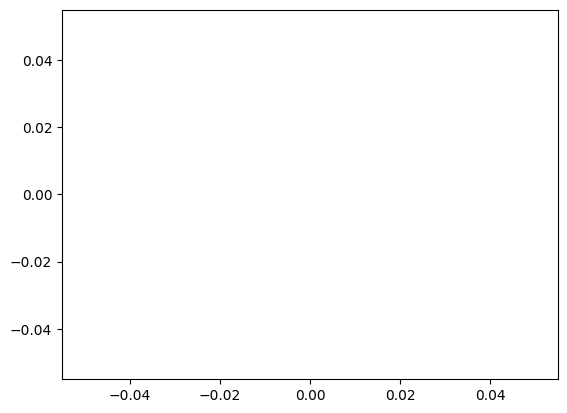

In [42]:
dd= [x.get('loss') for x in trainer.state.log_history if x.get('loss') is not None]
plt.plot(dd)

Once the training is completed, we can evaluate our model and get its perplexity on the validation set like this:

In [43]:
import math
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 16.20


The perplexity is still quite high since for this demo we trained on a small dataset for a small number of epochs. For a real LM training, you  would need a larger dataset and more epochs.

In [50]:
tt = '오브젠 AI LAB'
input_ids = tokenizer.encode(tt, return_tensors='pt').to('cuda')
gen_ids = model.generate(input_ids,
                         max_length=128,
                         repetition_penalty=2.0,
                         pad_token_id=tokenizer.pad_token_id,
                         eos_token_id=tokenizer.eos_token_id,
                         bos_token_id=tokenizer.bos_token_id,
#                          do_sample=True,
                         use_cache=True)
generated = tokenizer.decode(gen_ids[0])
print(generated)

오브젠 AI LAB은 데이터 분석 및 시각화 솔루션을 제공하는 국내 유일의 기업입니다.  [오브제 제품 개요] 마케팅 자동화/자동화 기술 (CMS, Customer Management System) obzen DataIntelligence는 빅데이터와 인공지능 기술을 기반으로 한 실시간 고객 행동 예측 알고리즘으로, 마케터가 고객의 행동을 예측할 수 있도록 지원합니다. 이를 통해 고객이 어떤 상품에 대해 더 많이 구매할 것인지 사전에 알고, 그 결과도 확인할 수도 있습니다. 또한 해당 상품에서 가장 중요한 것은 바로 ‘고객 반응’ 입니다. 이는 곧 고객을 이해하고 이해한다는 것입니다.


In [45]:
model.save_pretrained('./obgpt')

You can now upload the result of the training to the Hub, just execute this instruction:

In [46]:
# trainer.push_to_hub()

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("sgugger/my-awesome-model")
```

---

## Masked language modeling

For masked language modeling (MLM) we are going to use the same preprocessing as before for our dataset with one additional step: we will randomly mask some tokens (by replacing them by `[MASK]`) and the labels will be adjusted to only include the masked tokens (we don't have to predict the non-masked tokens). If you use a tokenizer you trained yourself, make sure the `[MASK]` token is among the special tokens you passed during training!

We will use the [`bert-base-cased`](https://huggingface.co/bert-based-cased) model for this example. You can pick any of the checkpoints listed [here](https://huggingface.co/models?filter=masked-lm) instead. For the tokenizer, replace the checkpoint by the one you trained.

In [ ]:
model_checkpoint = "bert-base-cased"
tokenizer_checkpoint = "sgugger/bert-like-tokenizer"

We can apply the same tokenization function as before, we just need to update our tokenizer to use the checkpoint we just picked:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)
tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

https://huggingface.co/sgugger/bert-like-tokenizer/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /home/sgugger/.cache/huggingface/transformers/tmpj0hlre6a


storing https://huggingface.co/sgugger/bert-like-tokenizer/resolve/main/tokenizer_config.json in cache at /home/sgugger/.cache/huggingface/transformers/8e2bf16fe90bdd2f922f692d28792f71927c19b3ec57cf1457567cd848515842.0bbe47aa0e39b09ed05a95f7d42a27299232ce8e9ef28608e8f8a1cb57a74c0a
creating metadata file for /home/sgugger/.cache/huggingface/transformers/8e2bf16fe90bdd2f922f692d28792f71927c19b3ec57cf1457567cd848515842.0bbe47aa0e39b09ed05a95f7d42a27299232ce8e9ef28608e8f8a1cb57a74c0a
https://huggingface.co/sgugger/bert-like-tokenizer/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /home/sgugger/.cache/huggingface/transformers/tmpceo1r0j0


storing https://huggingface.co/sgugger/bert-like-tokenizer/resolve/main/vocab.txt in cache at /home/sgugger/.cache/huggingface/transformers/d2c888a76d867b3c110720b637a5958d9748e157d245806d646a7c015a393b95.7b1a250944f9d3669d4f57ab97b1f6a21a494a84cff113694cf15d673e7bb6d5
creating metadata file for /home/sgugger/.cache/huggingface/transformers/d2c888a76d867b3c110720b637a5958d9748e157d245806d646a7c015a393b95.7b1a250944f9d3669d4f57ab97b1f6a21a494a84cff113694cf15d673e7bb6d5


https://huggingface.co/sgugger/bert-like-tokenizer/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /home/sgugger/.cache/huggingface/transformers/tmp9i7md8wn


storing https://huggingface.co/sgugger/bert-like-tokenizer/resolve/main/tokenizer.json in cache at /home/sgugger/.cache/huggingface/transformers/f385664afe38b7f081454cb8d1aa1ff0c4e16507dfbafe1fad8fc85538262261.159bf1d23803f236f036667eafea5ec2d6b22bcaf4b88d1dafeb8e6c7c35d6f9
creating metadata file for /home/sgugger/.cache/huggingface/transformers/f385664afe38b7f081454cb8d1aa1ff0c4e16507dfbafe1fad8fc85538262261.159bf1d23803f236f036667eafea5ec2d6b22bcaf4b88d1dafeb8e6c7c35d6f9


https://huggingface.co/sgugger/bert-like-tokenizer/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /home/sgugger/.cache/huggingface/transformers/tmp58nljjm6


storing https://huggingface.co/sgugger/bert-like-tokenizer/resolve/main/special_tokens_map.json in cache at /home/sgugger/.cache/huggingface/transformers/c90d08712ec5954e9bf3853df3bab5a6549e408225f4e9b6dd90f3bc3d3c0461.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /home/sgugger/.cache/huggingface/transformers/c90d08712ec5954e9bf3853df3bab5a6549e408225f4e9b6dd90f3bc3d3c0461.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/sgugger/bert-like-tokenizer/resolve/main/vocab.txt from cache at /home/sgugger/.cache/huggingface/transformers/d2c888a76d867b3c110720b637a5958d9748e157d245806d646a7c015a393b95.7b1a250944f9d3669d4f57ab97b1f6a21a494a84cff113694cf15d673e7bb6d5
loading file https://huggingface.co/sgugger/bert-like-tokenizer/resolve/main/tokenizer.json from cache at /home/sgugger/.cache/huggingface/transformers/f385664afe38b7f081454cb8d1aa1ff0c4e16507dfbafe1fad8fc85538262261.159bf1d23803f236f03

Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (554 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


And like before, we group texts together and chunk them in samples of length `block_size`. You can skip that step if your dataset is composed of individual sentences.

In [ ]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

The rest is very similar to what we had, with two exceptions. First we use a model suitable for masked LM:

In [ ]:
from transformers import AutoConfig, AutoModelForMaskedLM

config = AutoConfig.from_pretrained(model_checkpoint)
model = AutoModelForMaskedLM.from_config(config)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /home/sgugger/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}



We redefine our `TrainingArguments`:

In [ ]:
training_args = TrainingArguments(
    "test-clm",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=True,
    push_to_hub_model_id=f"{model_checkpoint}-wikitext2",
)

Like before, the last two arguments are to setup everything so we can push the model to the [Hub](https://huggingface.co/models) at the end of training. Remove the two of them if you didn't follow the installation steps at the top of the notebook, otherwise you can change the value of `push_to_hub_model_id` to something you would prefer.

Finally, we use a special `data_collator`. The `data_collator` is a function that is responsible of taking the samples and batching them in tensors. In the previous example, we had nothing special to do, so we just used the default for this argument. Here we want to do the random-masking. We could do it as a pre-processing step (like the tokenization) but then the tokens would always be masked the same way at each epoch. By doing this step inside the `data_collator`, we ensure this random masking is done in a new way each time we go over the data.

To do this masking for us, the library provides a `DataCollatorForLanguageModeling`. We can adjust the probability of the masking:

In [ ]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

Then we just have to pass everything to `Trainer` and begin training:

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
    data_collator=data_collator,
)

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 18761
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7038


Epoch,Training Loss,Validation Loss
1,7.091100,7.049844
2,6.905400,6.870386
3,6.856900,6.888713


Saving model checkpoint to test-clm/checkpoint-500
Configuration saved in test-clm/checkpoint-500/config.json
Model weights saved in test-clm/checkpoint-500/pytorch_model.bin
Saving model checkpoint to test-clm/checkpoint-1000
Configuration saved in test-clm/checkpoint-1000/config.json
Model weights saved in test-clm/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to test-clm/checkpoint-1500
Configuration saved in test-clm/checkpoint-1500/config.json
Model weights saved in test-clm/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to test-clm/checkpoint-2000
Configuration saved in test-clm/checkpoint-2000/config.json
Model weights saved in test-clm/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2009
  Batch size = 8
Saving model checkpoint to test-clm/checkpoint-2500
Configuration saved in test-clm/checkpoint-2500/config.json
Model weights saved in test-clm/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to test-clm/checkpo

TrainOutput(global_step=7038, training_loss=7.04967836345858, metrics={'train_runtime': 790.1373, 'train_samples_per_second': 71.232, 'train_steps_per_second': 8.907, 'total_flos': 4683068522136576.0, 'train_loss': 7.04967836345858, 'epoch': 3.0})

Like before, we can evaluate our model on the validation set. The perplexity is much lower than for the CLM objective because for the MLM objective, we only have to make predictions for the masked tokens (which represent 15% of the total here) while having access to the rest of the tokens. It's thus an easier task for the model.

In [ ]:
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 2009
  Batch size = 8


Perplexity: 947.45


The perplexity is still quite high since for this demo we trained on a small dataset for a small number of epochs. For a real LM training, you  would need a larger dataset and more epochs.

You can now upload the result of the training to the Hub, just execute this instruction:

In [ ]:
trainer.push_to_hub()

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForMaskedLM

model = AutoModelForMaskedLM.from_pretrained("sgugger/my-awesome-model")
```